# Objekterkennung und Tracking á la CbTRAM

Der Ansatz aus Zinner et al. (2008) könnte interessant sein, um die Objektdefinition zu verbessern. Der Ansatz basiert auf drei Stadien. Interessant sind insbesondere die Definitionen der ersten beiden Stadien und die Verwendung der Bewegungsfelder.

Doch zunächst benötigen wir einige Pakete.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import datetime as dt

from scipy import ndimage as ndi

import sys
sys.path.append("/vols/talos/home/stephan/utils/tracking/")
import tracking_common as tc

from analysis_tools import optical_flow as oflow

import xarray as xr

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Stadium 1: konvektive Auslösung

Der Ansatz für das erste Stadium geht vom HRV-Kanal aus. Die Grundidee ist, Wolken zu finden, die wachsen. Dazu wird das HRV-Bild eines Zeitpunktes t mit dem des Zeitpunktes t-1 verglichen. Das Bild des Zeitpunktes t-1 wird mittels eines Flussfeldes verschoben und dann die Differenz ΔHRV = HRV$_\mathrm{t}$ – HRV$_\mathrm{t-1}$ gebildet. Das Flussfeld wird dabei NICHT von den HRV-Bildern abgeleitet sondern aus den gelätteten IR10.8-Bildern der Zeisschritte t-2 und t-1, da die Bewegung im Flussfeld aus den HRV-Bildern nicht nur aus der Advektion sondern auch aus den Entwicklungen herrührt, die analysiert werden sollen.

Das ΔHRV wird mit einem ΔIR-Feld verglichen, dass so ähnlich wie das ΔHRV-Feld abgeleitet wird, nur dass das Bewegungsfeld dafür aus dem WV062-Kanal stammt. Da sich nicht alle Wolken im HRV konvektiv sind und sich auch nicht alle Cumuli humiles zu Cumolonimbi entwicklen, werden nur Wolken betrachtete, deren Flächenzunahme durch eine eine Abkühlung im IR-Feld gestützt wird. Dafür wird ein Qualitätsindikator aus den beiden Feldern ΔHRV und ΔIR gebildete. Dafür weden sie zunächst dann normalisiert und dann multipliziert um das Qualitätsfeld -ΔHRV $\cdot$ ΔIR zu erhalten, das Bereiche mit Wolkenwachstum anzeigt.

Um das auszuprobieren laden wir zunächst die Satellitendaten für ein Beispiel. Um keine Information beim Vergleich des IR-10,8-µm-Kanals mit dem HRV-Kanal zu verlieren, benutzen wir die auf HRV-Auflösung interpolierten Satellitendaten.

In [1]:
data_path = "/vols/talos/home/stephan/proj/2019-01_trackingstudie/hires_files/calibrated/"

In [83]:
t2 = dt.datetime(2013,6,18,12,25)# t-2
t1 = dt.datetime(2013,6,18,12,30) # t-1
t0 = dt.datetime(2013,6,18,12,35) # t0

sat_fields = ['hrv','ir_108','wv_062']

In [84]:
sat_data = {f:[] for f in sat_fields}
for t in [t2,t1,t0]:
    file_name = "{dp}msg2-sevi-{d}-hr-cal-vap-rss.de.c3.nc".format(dp=data_path,
                                                                   d = t.strftime("%Y%m%dT%H%MZ"))
    
    data = xr.open_dataset(file_name)
    
    for field in sat_fields:
        sat_data[field].append(data[field].data)

Als nächstes berechnen wir die benötigen Bewegungsfelder. Im CbTRAM-Artrikel wird das IR-Feld mit einem gleitenden Mittelwertfilter über 25 km geglättet, das entspricht also etwa 7 Standardpixeln oder 25 HRV-Pixeln.

In [86]:
ir_smooth = [ndi.filters.uniform_filter(ir_field,25) for ir_field in sat_data['ir_108']]
wv_smooth = [ndi.filters.uniform_filter(wv_field,25) for wv_field in sat_data['wv_062']]

Text(0.5,1,u'gegl\xe4ttet')

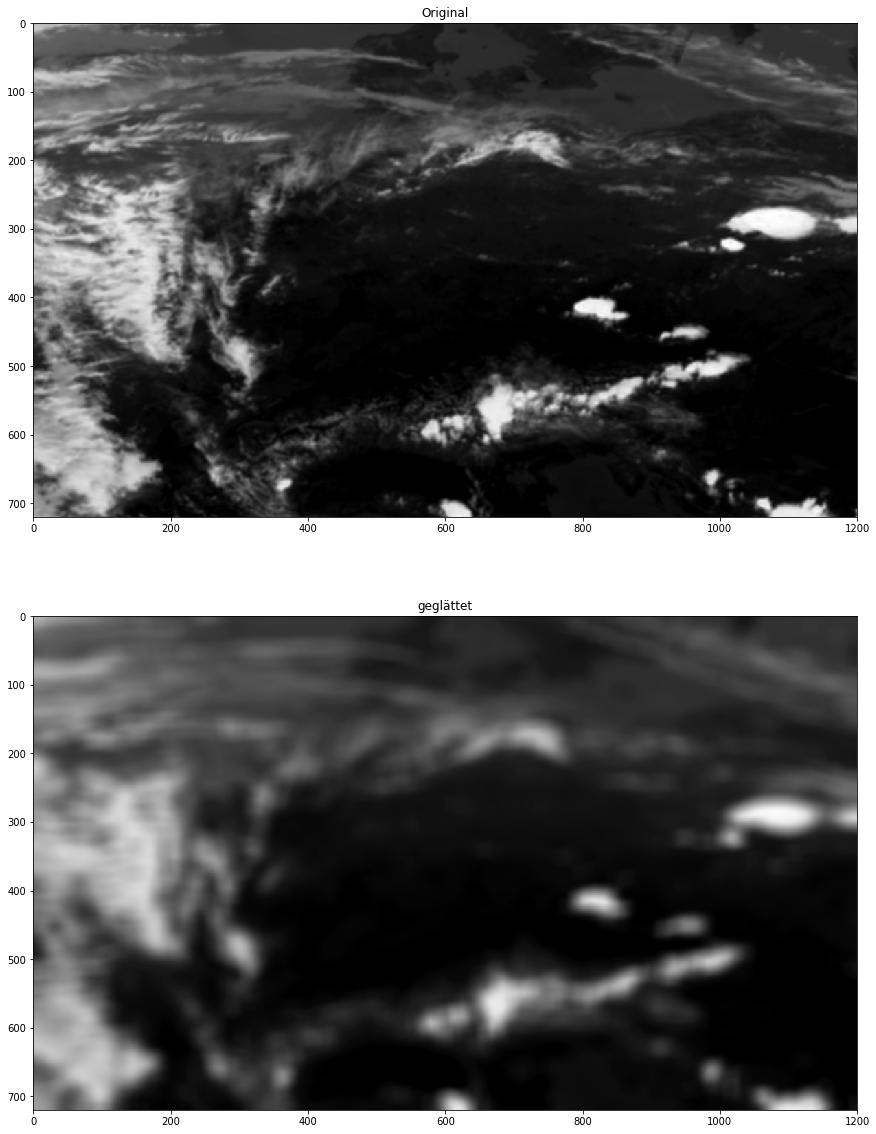

In [87]:
fig,ax = plt.subplots(2,1,figsize = (16,20))
ax[0].imshow(sat_data['ir_108'][0],vmin=210,vmax=300,cmap='gray_r')
ax[0].set_title("Original")
ax[1].imshow(ir_smooth[0],vmin=210,vmax=300,cmap='gray_r')
ax[1].set_title(u"geglättet")

Nun können wir das Bewegungsfeld ermitteln.

In [88]:
ir_movement = tc.oft.calculate_optical_flow([sat_data['ir_108'][0],sat_data['ir_108'][1]],'farnebaeck')

Mit diesem Flussfeld, wird jetzt das HRV-Bild des Zeitpunktes t-1 auf t verschoben.

In [89]:
hrv_moved = oflow.morph_trans_opt_flow(sat_data['hrv'][-2],ir_movement[0])

Als nächstes berechnen wir die Differenz zwischen tatsächlichem und geschätzten Bild, um Bereiche mit Wolkenwachstum zu ermitteln.

In [90]:
DHRV = sat_data['hrv'][-1] - hrv_moved

In [91]:
def colourbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

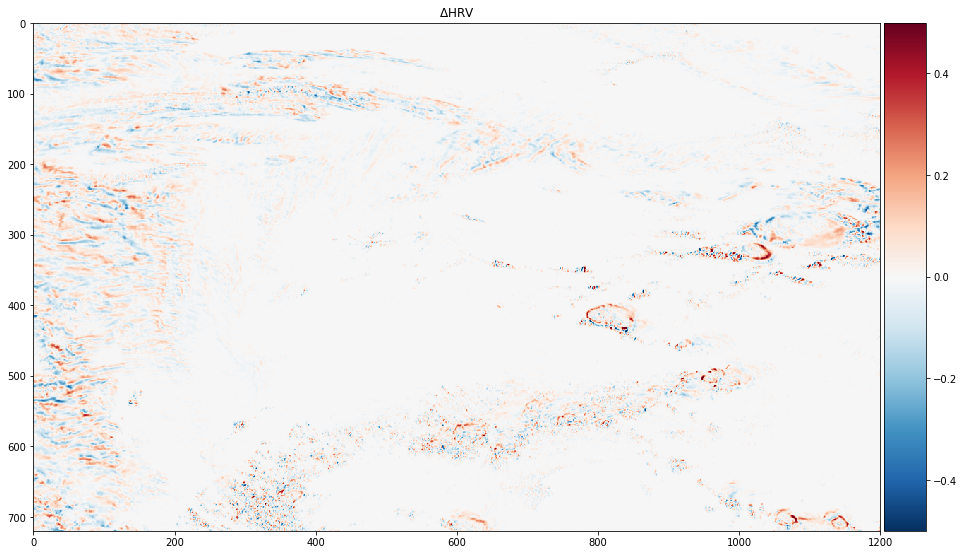

In [92]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
d_plot = ax.imshow(DHRV,vmin=-0.5,vmax=0.5,cmap='RdBu_r')
ax.set_title(r"$\Delta$HRV")
colourbar(d_plot)

Alle Bereiche mit einem positiven Wert weisen auf Wolkenwachstum hin. Um sicher zu gehen, betrachten wir die IR-Felder.

In [93]:
#wv_hires = [upsample_image(wv) for wv in sat_data['WV_062']]
wv_smooth = [ndi.filters.uniform_filter(wv_field,25) for wv_field in sat_data['wv_062']]
wv_movement = tc.oft.calculate_optical_flow([sat_data['wv_062'][0],sat_data['wv_062'][1]],'farnebaeck')
ir_moved = oflow.morph_trans_opt_flow(sat_data['ir_108'][-2],wv_movement[0])

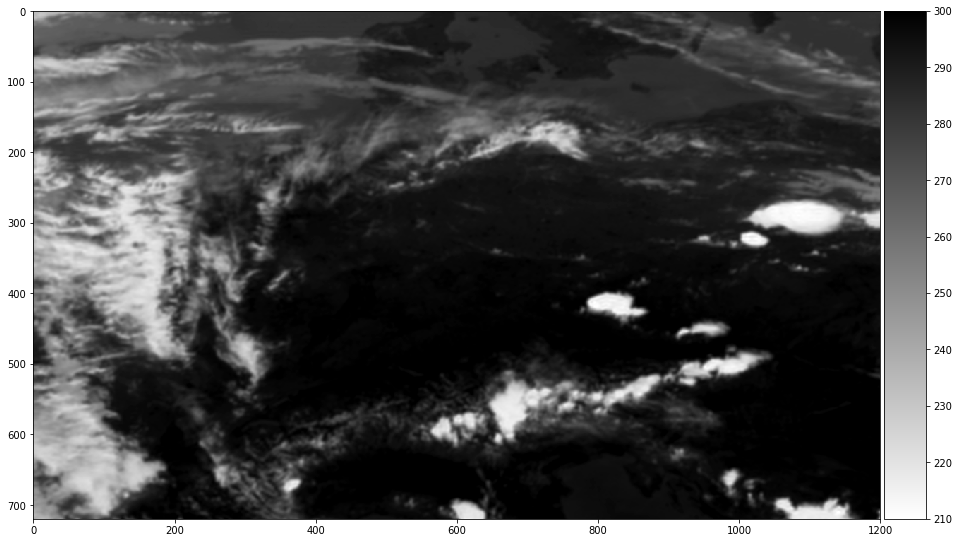

In [94]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
d_plot = ax.imshow(ir_moved,vmin=210,vmax=300,cmap='gray_r')
colourbar(d_plot)

In [95]:
DIR = sat_data['ir_108'][-1] - ir_moved

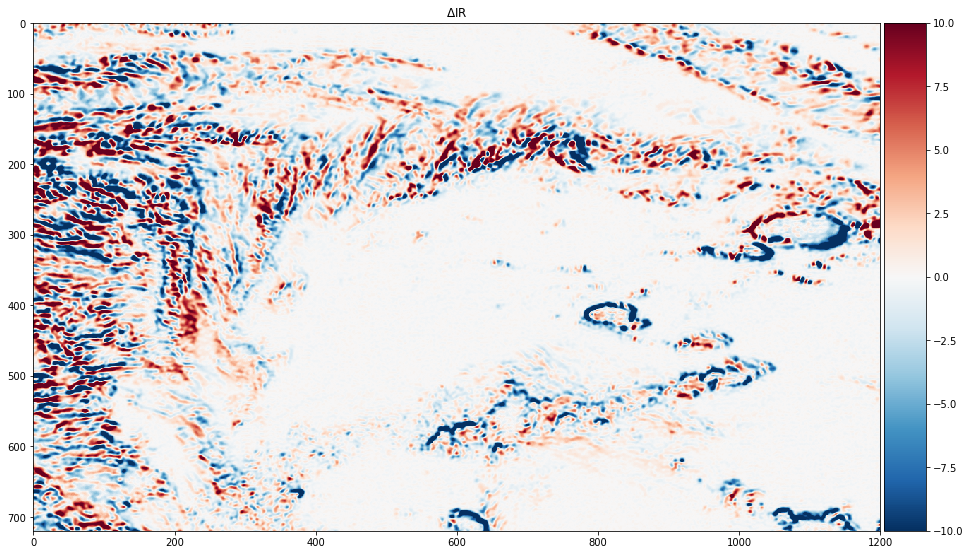

In [96]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
d_plot = ax.imshow(DIR,vmin=-10,vmax=10,cmap='RdBu_r')
ax.set_title(r"$\Delta$IR")
colourbar(d_plot)

Hier deuten alle Bereiche mit einer Abkühlung auf Wolkenwachstum hin.

Als nächstes werden beide Felder normalisiert.

In [106]:
def scale(x, out_range=(-1, 1)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [162]:
def scale_mean_center(x,out_range=(0,1)):
    # rescale data into rnge [0,1]
    x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
    
    # center data around mean
    x_centered = x_scaled - np.mean(x_scaled)
    
    return x_centered * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [165]:
DIR_norm = scale_mean_center(DIR)
DHRV_norm = scale_mean_center(DHRV)

Text(0.5,1,'$\\Delta$HRV, normalisiert')

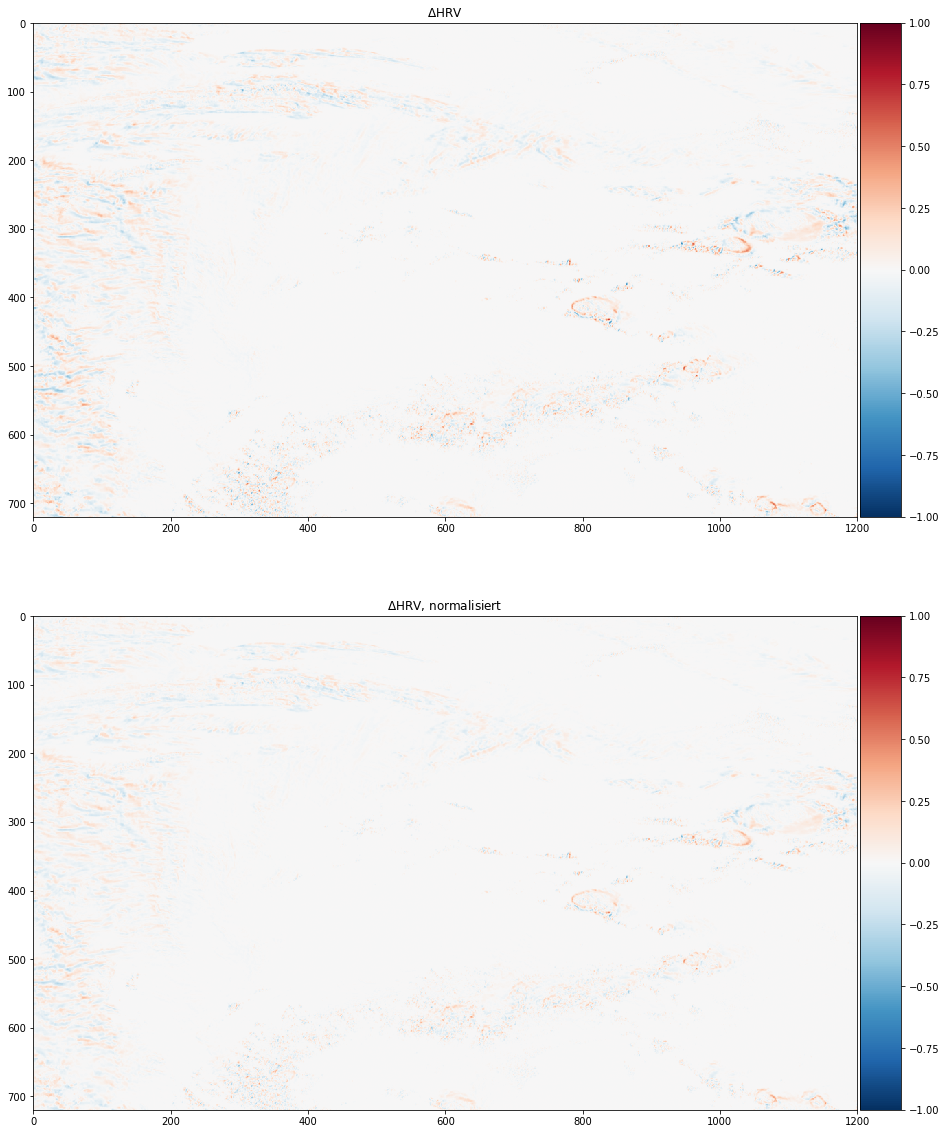

In [166]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
hrv_plot = ax[0].imshow(DHRV,vmin=-1,vmax=1,cmap='RdBu_r')
colourbar(hrv_plot)
ax[0].set_title(r"$\Delta$HRV")
hrv1_plot = ax[1].imshow(DHRV_norm,vmin=-1,vmax=1,cmap='RdBu_r')
colourbar(hrv1_plot)
ax[1].set_title(r"$\Delta$HRV, normalisiert")

Daraus wird jetzt der Indikator für das Wolkenwachstum berechnet.

In [167]:
indicator = -DHRV_norm * DIR_norm

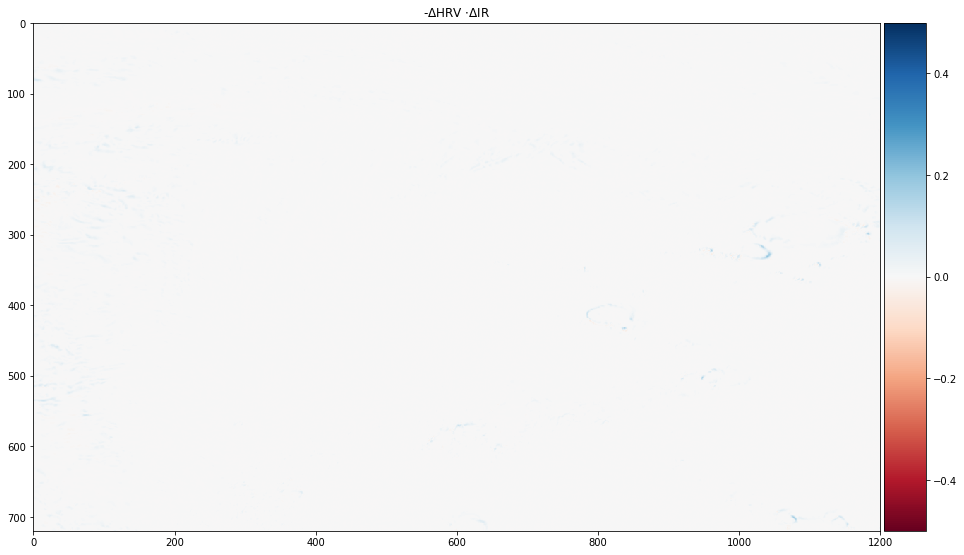

In [168]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
indd_plot = ax.imshow(indicator,vmin=-.5,vmax=.5,cmap='RdBu')
ax.set_title(r"-$\Delta$HRV $\cdot \Delta$IR")
colourbar(indd_plot)

Die blauen Bereiche sind Regionen mit Wolkenwachstum und die roten welche mit Wolkenauflösung.

Um wirklich interessante Objekte zu erhalten, muss ein Schwellwert auf das Feld angewendet werden. In Zinner et at. (2008) wird dreimal die Standardabweichung für die ΔHRV- und ΔIR-Felder verwendet. Wie der Schwellwert genau berechnet wird, wird nicht angegeben. Da die Felder im Bereich -1 bis 1 normalisiert werden, sollte, wenn sie normal verteilt sind, der Mittelwert 0 sein. Daher sollte $3\sigma$ oder $-3\sigma$ direkt als Schwellwert benutzt werden können. Für den HRV-Kanal kommt noch hinzu, dass alle Bereiche mit einer Reflektivität von wengier als 0,5 ausmaskiert werden.

In [169]:
threshold_DHRV = 3* np.std(DHRV_norm)
threshold_DIR = - 3* np.std(DIR_norm)

In [170]:
threshold_DHRV

0.09226322562929386

In [171]:
threshold_DIR 

-0.1112605049808463

In [172]:
threshold_indicator = -threshold_DHRV * threshold_DIR
threshold_indicator

0.010265253074676996

In [173]:
DHRV_objects = np.ma.masked_less(DHRV_norm,threshold_DHRV)
DHRV_objects = np.ma.masked_less(DHRV_objects,0.5)

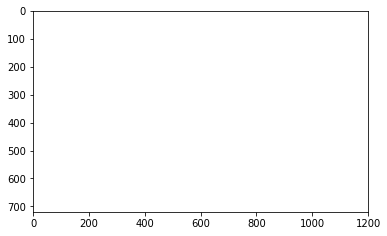

In [174]:
plt.imshow(DHRV_objects*1)

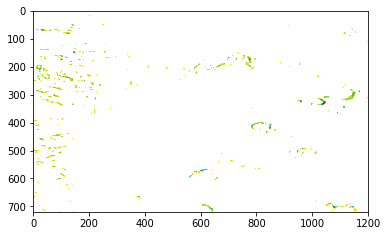

In [175]:
DIR_objects = np.ma.masked_greater(DIR_norm,threshold_DIR)
plt.imshow(DIR_objects*1)

In [176]:
hrv_mask = np.ma.masked_less(np.clip(sat_data['hrv'][-1],0,1),0.5)
level1_mask = np.ma.masked_less(indicator,threshold_indicator)

level1_mask = ~hrv_mask.mask & ~level1_mask.mask

Text(0.5,1,u'Objekte mit konvektiver Ausl\xf6sung')

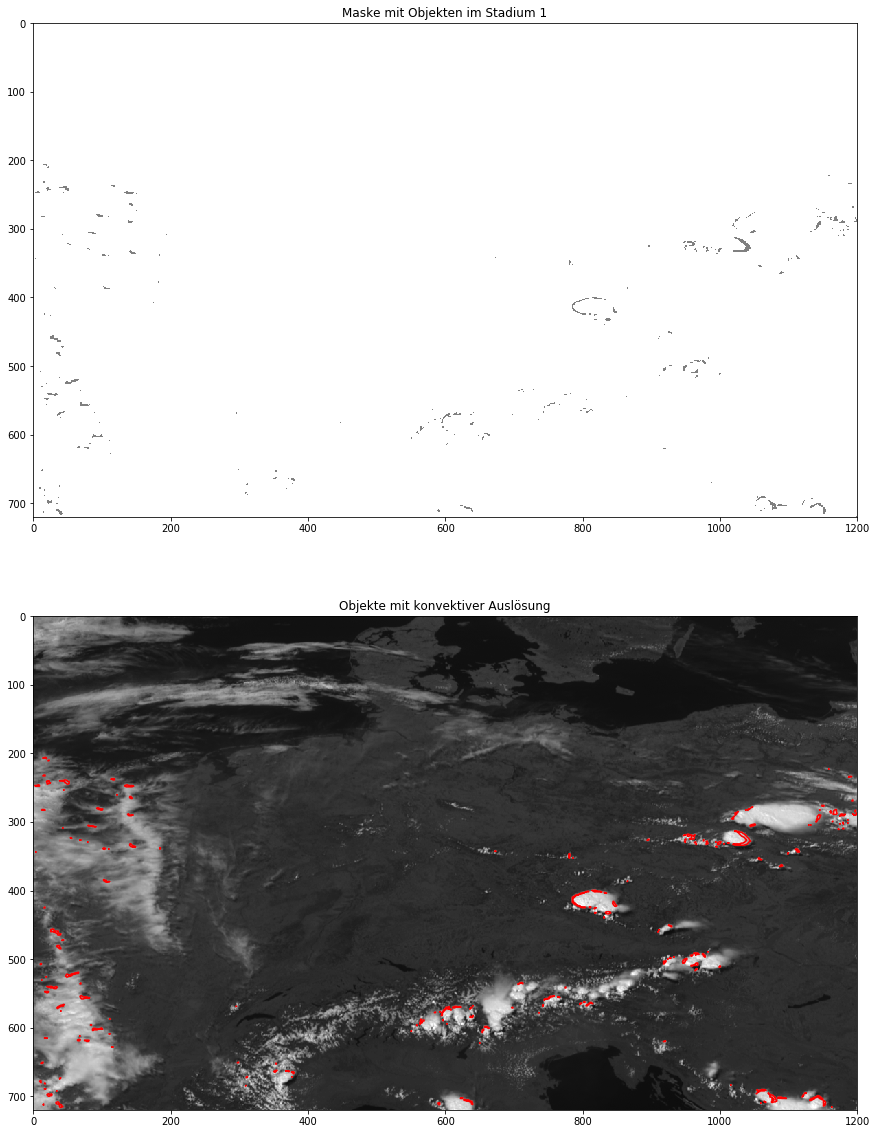

In [177]:
fig,ax = plt.subplots(2,1,figsize=(16,20))
ax[0].imshow(~level1_mask,vmin=-1,vmax=1,cmap='gray')
ax[0].set_title(u"Maske mit Objekten im Stadium 1")
ax[1].imshow(np.clip(sat_data['hrv'][-1],0,1),vmin=0,vmax=1,cmap='gray')
ax[1].contour(~level1_mask*1,levels=1,colors='red')
ax[1].set_title(u"Objekte mit konvektiver Auslösung")

Das sieht im Großen und Ganzen recht vernünftig aus, ist aber ziemlich auf die Randbereiche bereits existerender Konvektion fixiert.

## Stadium 2: rasche Abkühlung

Dann versuchen wir mal Objekte des 2. Stadiums zu finden.

Dafür gehen wir genauso vor, wie zuvor, nur dass wir jetzt den WV062-Kanal benutzen. Der Fluss stammt auch von diesem Kanal, aber von den zwei Zeitschritten zuvor.

In [178]:
wv_moved = oflow.morph_trans_opt_flow(sat_data['wv_062'][1],wv_movement[0])

DWV = sat_data['wv_062'][-1] - wv_moved

Text(0.5,1,'$\\Delta$WV')

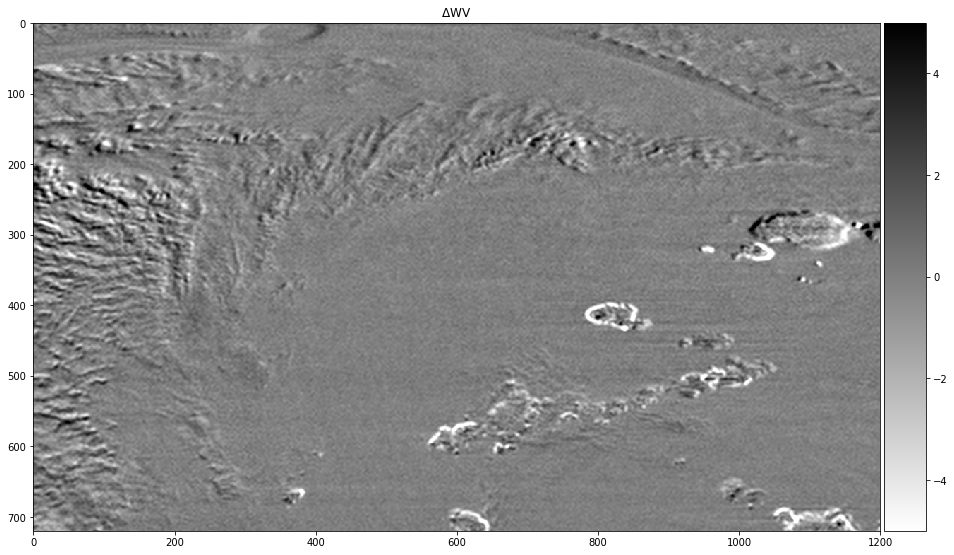

In [179]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
wv_plot = ax.imshow(DWV,vmin=-5,vmax=5,cmap='binary')
colourbar(wv_plot)
ax.set_title(r"$\Delta$WV")

Die hellen Bereiche reflektieren Gebiete mit Abkühlung und die dunklen welche mit Erwärmung.

In [180]:
#DWV_norm = tc.scale_array_min_max(DWV,new_max=1,new_min=-1)
DWV_norm = scale_mean_center(DWV)
#threshold_DWV = np.mean(DWV_norm) - 3 * np.std(DWV_norm)
threshold_DWV = - 3 * np.std(DWV_norm)

#level2_mask = np.ma.masked_greater(DWV_norm,-threshold_DWV)
level2_mask = np.ma.masked_greater(DWV_norm,threshold_DWV)

Text(0.5,1,'$\\Delta$WV, normalisiert')

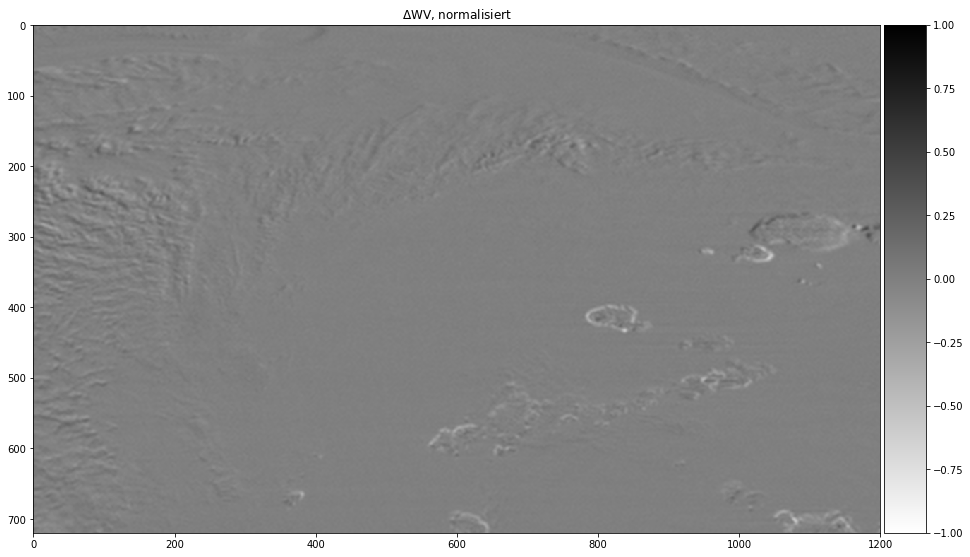

In [181]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
wv_plot = ax.imshow(DWV_norm,vmin=-1,vmax=1,cmap='binary')
colourbar(wv_plot)
ax.set_title(r"$\Delta$WV, normalisiert")

In [182]:
3 * np.std(DWV_norm)

0.09208271992660602

(array([7.00000e+00, 8.00000e+00, 1.40000e+01, 7.00000e+00, 1.70000e+01,
        1.50000e+01, 1.70000e+01, 2.60000e+01, 3.50000e+01, 5.70000e+01,
        6.10000e+01, 1.15000e+02, 1.58000e+02, 2.55000e+02, 3.72000e+02,
        6.24000e+02, 9.87000e+02, 1.56400e+03, 2.58000e+03, 4.91100e+03,
        1.02630e+04, 2.39730e+04, 8.33680e+04, 4.88573e+05, 1.93099e+05,
        3.28120e+04, 1.14070e+04, 4.55400e+03, 2.07400e+03, 1.01200e+03,
        4.60000e+02, 2.70000e+02, 1.34000e+02, 6.50000e+01, 4.30000e+01,
        2.40000e+01, 1.60000e+01, 1.30000e+01, 5.00000e+00, 5.00000e+00]),
 array([-0.59088867, -0.56588867, -0.54088867, -0.51588867, -0.49088867,
        -0.46588867, -0.44088867, -0.41588867, -0.39088867, -0.36588867,
        -0.34088867, -0.31588867, -0.29088867, -0.26588867, -0.24088867,
        -0.21588867, -0.19088867, -0.16588867, -0.14088867, -0.11588867,
        -0.09088867, -0.06588867, -0.04088867, -0.01588867,  0.00911133,
         0.03411133,  0.05911133,  0.08411133,  0

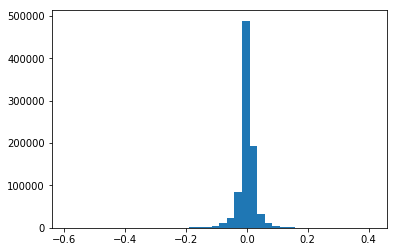

In [183]:
plt.hist(DWV_norm.ravel(),bins=40)

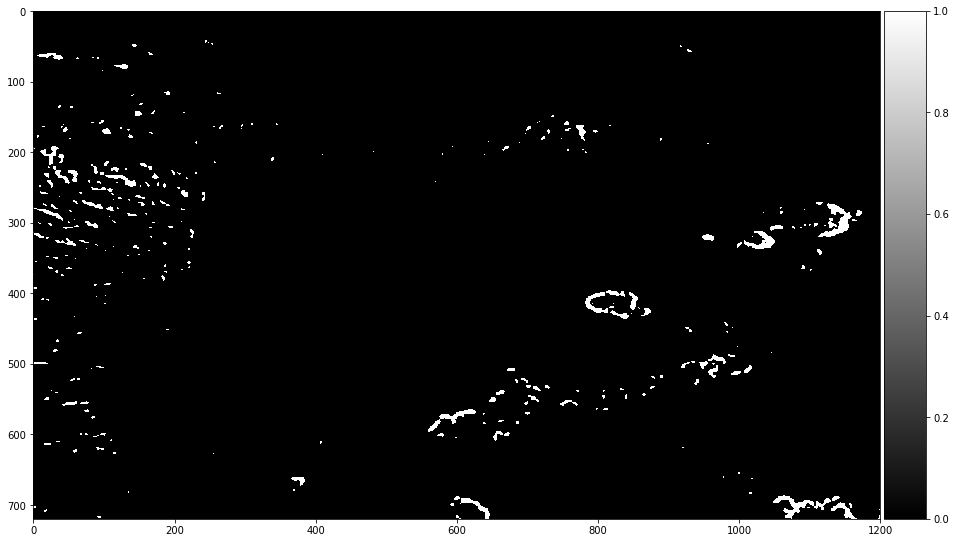

In [184]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
wv_plot = ax.imshow(~level2_mask.mask*1,vmin=0,vmax=1,cmap='binary_r')
colourbar(wv_plot)

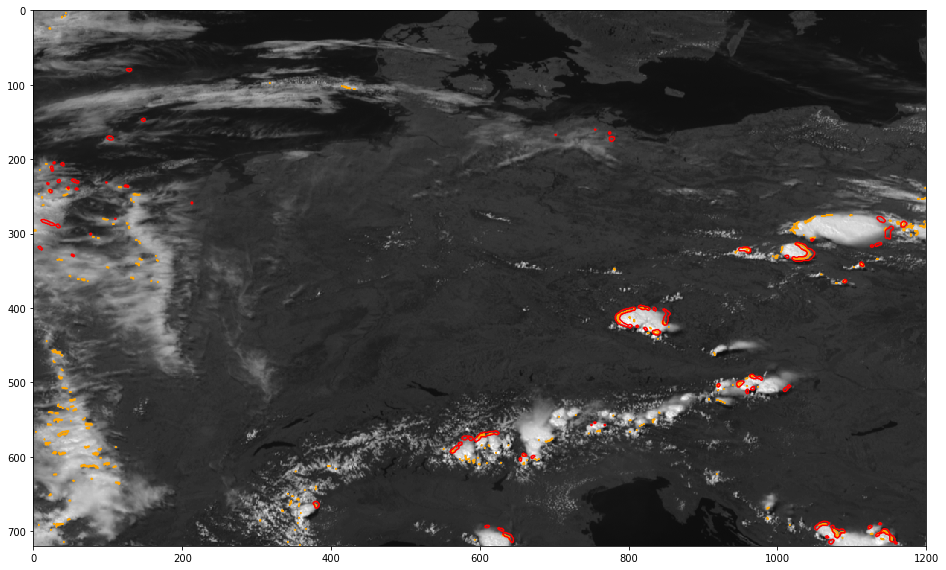

In [132]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.clip(sat_data['hrv'][-1],0,1),vmin=0,vmax=1,cmap='gray')
ax.contour(~level1_mask*1,levels=1,colors='orange')
ax.contour(~level2_mask.mask*1,levels=1,colors='red')

In [135]:
combined_masks = np.zeros_like(sat_data['hrv'][0])

combined_masks[np.where(level1_mask==True)] = 1
combined_masks[np.where(level2_mask.mask==False)] = 2

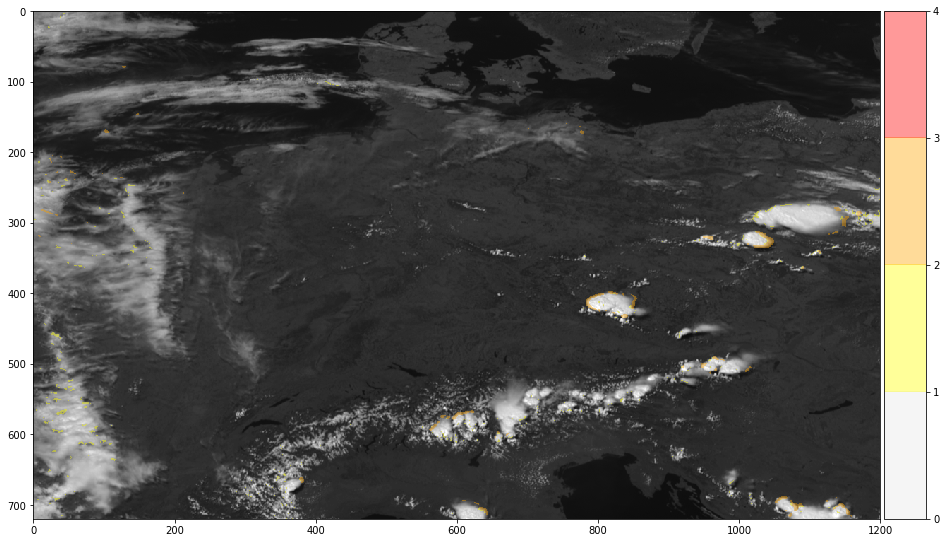

In [136]:
from matplotlib import colors

# make a color map of fixed colors
cmap = colors.ListedColormap([(0.9,0.9,0.9,0),'yellow','orange','red'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(np.clip(sat_data['hrv'][-1],0,1),vmin=0,vmax=1,cmap='gray')
level_plot = ax.imshow(combined_masks,cmap=cmap, norm=norm, alpha=0.4)
colourbar(level_plot)

Das sieht im Großen ung Ganzen auch vernünftig aus.

/home/lenk/.local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


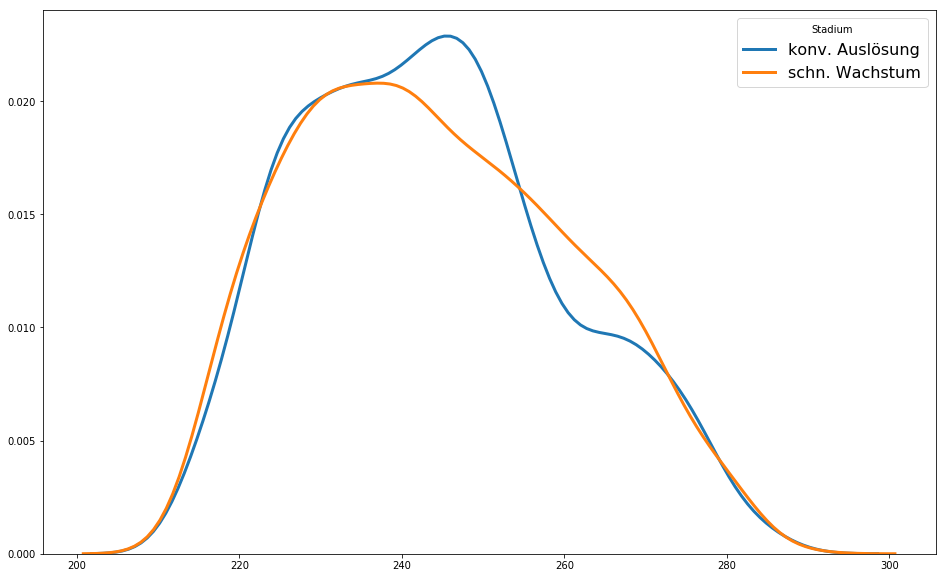

In [137]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(16,10))
levels = {1:u'konv. Auslösung', 2:'schn. Wachstum'}
for level in [1,2]:
    values = sat_data['ir_108'][-1][np.where(combined_masks==level)]
    
    # Draw the density plot
    sns.distplot(values, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = levels[level],ax=ax)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Stadium')